In [1]:
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

pi = np.pi

import constants

q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']

import solvers
import particles
import fields
import analytic_models

from solvers import symplectic_maps
maps = symplectic_maps()

 

In [36]:

def plot_beam(beam):

    plt.figure()
    plt.subplot(2,2,1)
    plt.hexbin(beam.x, beam.px / beam.pt)
    
    plt.subplot(2,2,2)
    plt.hexbin(beam.y, beam.py / beam.pt)
    
    plt.subplot(2,2,3)
    plt.hexbin(beam.x, beam.y)
    
    plt.subplot(2,2,4)
    plt.hexbin(beam.px / beam.pt, beam.py / beam.pt)
    
    plt.show()

def plot_saa_beam(beam):
    plt.figure()
    plt.subplot(2,2,1)
    plt.hexbin(beam.x, beam.xp)
    
    plt.subplot(2,2,2)
    plt.hexbin(beam.y, beam.yp)
    
    plt.subplot(2,2,3)
    plt.hexbin(beam.x, beam.y)
    
    plt.subplot(2,2,4)
    plt.hexbin(beam.xp, beam.yp)
    
    plt.show()
    
    
class saa_dist: 
    
    def __init__(self, particles = particles):
        
        pz = particles.gamma * particles.m_0 * c * particles.weight * particles.beta
        self.x = particles.x
        self.xp = particles.px / pz
        self.y = particles.y
        self.yp = particles.py / pz
        

        
def compute_system_energy(particles, fields):
    
    h_drift = np.sum(np.sqrt((particles.beta * particles.p_xi)**2 - particles.px ** 2 
                    - particles.py ** 2 - (particles.weight * particles.m_0 * c) ** 2))
    
    fields.solver.compute_psi_particles(fields, particles)
    
    h_sc = - np.sum( particles.weight * particles.charge / (particles.beta * c) * fields.psi_vals)
    
    #es_energy = - fields.mode_coefficients * np.conj(fields.mode_coefficients) * fields.k_matrix_sq
    
    return np.abs(h_drift) # + h_sc) # + np.sum(es_energy))

In [37]:
## Particle definitions 
sigma_x = 0.1
sigma_xp = 1.0e-3

Q_mks = 1.0e-12
Q = constants.charge_mks_to_cgs(Q_mks)

n_particles = 10000
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 10 ## minimum wavelength to resolve

E = 200.0e6
ds = 1.0

## This is where we initialize a gaussian distribuiton
new_distribution = particles.distribution(N = n_particles)
new_distribution.construct_uniform_guassian_2D(sigma_x = sigma_x, 
                sigma_y = sigma_x, sigma_xp = sigma_xp, sigma_yp = sigma_xp)
## Particle distributions
my_beam = particles.particles_2D_tent(new_distribution, dx_tent = 1 * L_min, dy_tent = 1 * L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_p, K_e = E)

## Define the fields 
my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
	L_x_min = L_min, L_y_min = L_min)

print np.sqrt(np.dot(my_beam.x, my_beam.x) / n_particles)


## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_fields.register_solver(field_solver)

# Define small angle beam for comparing drift calculation
saa_beam = saa_dist(particles = my_beam)


0.09948507419691084


In [43]:
def one_turn_map(fields, particles):
    
    maps.drift(particles, ds = ds/2.)
    maps.space_charge_kick_2D(fields, particles, ds = 0)
    maps.drift(particles, ds = ds/2.)
    
def matrix_drift(beam, L):
    
    beam.x = beam.x + L * beam.xp
    beam.y = beam.y + L * beam.yp
    

    

In [44]:
k = 0
rms_x = []
rms_x_saa = []
H = []

while k < 50:

    one_turn_map(my_fields, my_beam)
    matrix_drift(saa_beam, ds)
    
    xx_saa = np.sqrt(np.dot(saa_beam.x, saa_beam.x) / len(saa_beam.x))
    xx = np.sqrt(np.dot(my_beam.x, my_beam.x) / len(my_beam.x))
    
    H.append(compute_system_energy(my_beam, my_fields))
    
    rms_x_saa.append(xx_saa)
    rms_x.append(xx)
    k = k + 1
    
    if k%10 == 0:
        print k



10
20
30
40
50


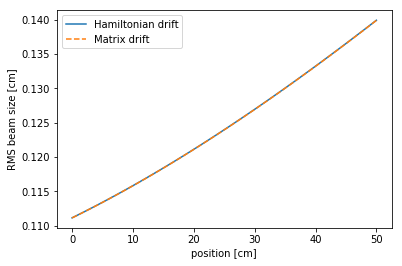

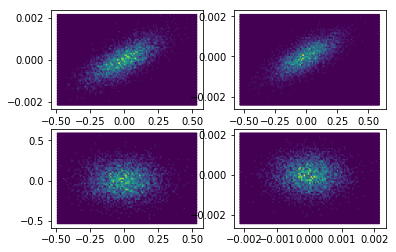

In [45]:
s = np.linspace(0, k * ds, k)
plt.figure()
plt.plot(s, rms_x, label = 'Hamiltonian drift')
plt.plot(s, rms_x_saa, '--', label ='Matrix drift')
plt.xlabel('position [cm]')
plt.ylabel('RMS beam size [cm]')
plt.legend(loc = 0)
plt.savefig('drift_validation.pdf')
plt.show()

plot_beam(my_beam)

angle_beam = saa_dist(particles = my_beam)

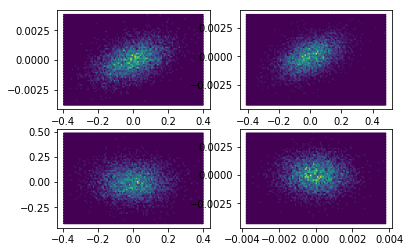

In [41]:
plot_saa_beam(angle_beam)

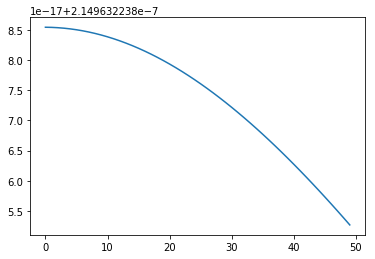

In [42]:
plt.figure()
plt.plot(H)
plt.show()

In [35]:
my_beam.weight

2496600.0456474447